####**SKENARIO 3 UNET**

**SPLIT DATA 80:20**

**AUGMENTASI OFFLINE**

**BATCH SIZE KLASIFIKASI 16 & 32**

**MENGGUNAKAN UNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path folder ALPUKAT di Google Drive
project_path = '/content/drive/MyDrive/alpukat/dataset'
os.chdir(project_path)


# Verifikasi isi folder
!ls

best_class1_rsunet01.h5  best_rsunet8_model.h5	 maskedunet01_test
best_class1_rsunet02.h5  best_unet01_model.h5	 maskedunet01_train
best_class1_rsunet1.h5	 best_unet02_model.h5	 maskedunet02_test
best_class1_rsunet2.h5	 best_unet1_model.h5	 maskedunet02_train
best_class1_rsunet7.h5	 best_unet2_model.h5	 maskedunet1_train
best_class1_rsunet8.h5	 best_unet3_model.h5	 maskedunet2_test
best_class1_unet01.h5	 best_unet4_model.h5	 maskedunet2_train
best_class1_unet02.h5	 images			 maskedunet3_test
best_class1_unet1.h5	 images_aug		 maskedunet3_train
best_class1_unet2.h5	 images_augment		 maskedunet4_test
best_class1_unet3.h5	 labels_converted.csv	 maskedunet4_train
best_class2_rsunet01.h5  labels.csv		 masks
best_class2_rsunet02.h5  labels.gsheet		 masks_aug
best_class2_rsunet1.h5	 logs			 masks_augment
best_class2_rsunet2.h5	 maskedrsunet01_test	 model.ipynb
best_class2_rsunet7.h5	 maskedrsunet01_train	 training_history1.json
best_class2_rsunet8.h5	 maskedrsunet02_test	 training_history2.js

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
import glob
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, SparseCategoricalAccuracy
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Reshape, Dense, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
image_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/images_aug/*.*'))  # Untuk semua tipe gambar
mask_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/masks_aug/*.*'))

print(len(image_paths))
print(len(mask_paths))

5850
5850


In [ ]:
label_map = {
    0: "miki",
    1: "aligator",
    2: "marcus"
}

# Jika kamu ingin tetap mendapatkan label numerik, kamu perlu membalik mapping-nya:
reverse_label_map = {v: k for k, v in label_map.items()}
labels = [reverse_label_map[os.path.basename(path).split('_')[0]] for path in image_paths]

In [ ]:
# Gunakan stratified split untuk menjaga proporsi kelas tetap
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_labels, test_labels = train_test_split(
    image_paths, mask_paths, labels,
    test_size=0.2,
    stratify=labels,   # menjaga distribusi kelas
    random_state=42
)


In [ ]:
from collections import Counter

# Hitung jumlah masing-masing label di data training
label_counts = Counter(train_labels)

# Tampilkan hasilnya
for label, count in label_counts.items():
    print(f"Label {label}: {count} data")


Label 2: 1560 data
Label 1: 1560 data
Label 0: 1560 data


##**DATA PREPROCESSING DAN AUGMENTASI**##

In [ ]:
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0

    # Thresholding untuk membentuk mask biner
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

In [ ]:
# Dataset untuk train
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

train_unet_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_unet_ds = train_unet_ds.map(lambda image_path, mask_path: load_and_preprocess_image(image_path, mask_path),
                                  num_parallel_calls=AUTOTUNE)
train_unet_ds = train_unet_ds.shuffle(100).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Dataset untuk test
test_unet_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_unet_ds = test_unet_ds.map(lambda image_path, mask_path: load_and_preprocess_image(image_path, mask_path),
                                num_parallel_calls=AUTOTUNE)
test_unet_ds = test_unet_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

##**UNET MODEL**##

In [ ]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
# --- U-Net Segmentasi ---
def build_unet():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output segmentasi
    segmentation_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(u9)

    model = models.Model(inputs=inputs, outputs=segmentation_output, name='U-Net-Segmenter')
    return model

In [ ]:
# Membuat model U-Net
unet_model = build_unet()

# Menampilkan summary dari model U-Net
unet_model.summary()

Model: "U-Net-Segmenter"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Menggunakan threshold 0.5 untuk prediksi
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [ ]:
# Kompilasi model
unet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Ganti dengan IoU loss jika sudah didefinisikan
    metrics=[iou_metric]
)

# Definisikan callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_unet01_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]

In [ ]:
# Melatih model
history = unet_model.fit(
    train_unet_ds,
    epochs=100,
    validation_data=test_unet_ds,
    steps_per_epoch=len(train_unet_ds),
    validation_steps=len(test_unet_ds),
    callbacks=callbacks
)

Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_metric: 0.3347 - loss: 0.3691

293/293 ━━━━━━━━━━━━━━━━━━━━ 1355s 4s/step - iou_metric: 0.3355 - loss: 0.3687 - val_iou_metric: 0.8323 - val_loss: 0.0909
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - iou_metric: 0.8379 - loss: 0.0867

293/293 ━━━━━━━━━━━━━━━━━━━━ 135s 274ms/step - iou_metric: 0.8380 - loss: 0.0867 - val_iou_metric: 0.9101 - val_loss: 0.0469
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - iou_metric: 0.9059 - loss: 0.0486

293/293 ━━━━━━━━━━━━━━━━━━━━ 102s 343ms/step - iou_metric: 0.9059 - loss: 0.0486 - val_iou_metric: 0.9335 - val_loss: 0.0341
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - iou_metric: 0.9244 - loss: 0.0391

293/293 ━━━━━━━━━━━━━━━━━━━━ 124s 282ms/step - iou_metric: 0.9244 - loss: 0.0390 - val_iou_metric: 0.9468 - val_loss: 0.0266
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - iou_metric: 0.9433 - loss: 0.0286

293/293 ━━━━━━━━━━━━━━━━━━━━ 92s 310ms/step - iou_metric: 0.9433 - loss: 0.0286 - val_iou_metric: 0.9578 - val_loss: 0.0209
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - iou_metric: 0.9438 - loss: 0.0284

293/293 ━━━━━━━━━━━━━━━━━━━━ 101s 338ms/step - iou_metric: 0.9438 - loss: 0.0284 - val_iou_metric: 0.9601 - val_loss: 0.0196
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - iou_metric: 0.9545 - loss: 0.0227

293/293 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - iou_metric: 0.9545 - loss: 0.0227 - val_iou_metric: 0.9666 - val_loss: 0.0161
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 131s 274ms/step - iou_metric: 0.9591 - loss: 0.0202 - val_iou_metric: 0.9546 - val_loss: 0.0234
Epoch 9/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 77s 259ms/step - iou_metric: 0.9623 - loss: 0.0185 - val_iou_metric: 0.9673 - val_loss: 0.0161
Epoch 10/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 86s 272ms/step - iou_metric: 0.9640 - loss: 0.0177 - val_iou_metric: 0.9627 - val_loss: 0.0183
Epoch 11/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - iou_metric: 0.9634 - loss: 0.0180

293/293 ━━━━━━━━━━━━━━━━━━━━ 91s 303ms/step - iou_metric: 0.9634 - loss: 0.0180 - val_iou_metric: 0.9717 - val_loss: 0.0134
Epoch 12/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - iou_metric: 0.9687 - loss: 0.0150

293/293 ━━━━━━━━━━━━━━━━━━━━ 148s 323ms/step - iou_metric: 0.9687 - loss: 0.0150 - val_iou_metric: 0.9721 - val_loss: 0.0133
Epoch 13/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 88s 299ms/step - iou_metric: 0.9717 - loss: 0.0134 - val_iou_metric: 0.9690 - val_loss: 0.0149
Epoch 14/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 134s 273ms/step - iou_metric: 0.9648 - loss: 0.0173 - val_iou_metric: 0.9701 - val_loss: 0.0144
Epoch 15/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 81s 272ms/step - iou_metric: 0.9659 - loss: 0.0171 - val_iou_metric: 0.9705 - val_loss: 0.0141
Epoch 16/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - iou_metric: 0.9670 - loss: 0.0162

293/293 ━━━━━━━━━━━━━━━━━━━━ 90s 305ms/step - iou_metric: 0.9671 - loss: 0.0162 - val_iou_metric: 0.9754 - val_loss: 0.0115
Epoch 17/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 128s 259ms/step - iou_metric: 0.9739 - loss: 0.0124 - val_iou_metric: 0.9751 - val_loss: 0.0119
Epoch 18/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - iou_metric: 0.9750 - loss: 0.0118

293/293 ━━━━━━━━━━━━━━━━━━━━ 90s 287ms/step - iou_metric: 0.9750 - loss: 0.0118 - val_iou_metric: 0.9773 - val_loss: 0.0106
Epoch 19/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 138s 273ms/step - iou_metric: 0.9766 - loss: 0.0110 - val_iou_metric: 0.9691 - val_loss: 0.0159
Epoch 20/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - iou_metric: 0.9595 - loss: 0.0213 - val_iou_metric: 0.9746 - val_loss: 0.0122
Epoch 21/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - iou_metric: 0.9702 - loss: 0.0151 - val_iou_metric: 0.9765 - val_loss: 0.0110
Epoch 22/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 77s 257ms/step - iou_metric: 0.9756 - loss: 0.0115 - val_iou_metric: 0.9770 - val_loss: 0.0107
Epoch 23/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 76s 257ms/step - iou_metric: 0.9769 - loss: 0.0108 - val_iou_metric: 0.9760 - val_loss: 0.0115
Epoch 24/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 257ms/step - iou_metric: 0.9485 - loss: 0.0306 - val_iou_metric: 0.9736 - val_loss: 0.0128
Epoch 25/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 258ms/s

293/293 ━━━━━━━━━━━━━━━━━━━━ 87s 276ms/step - iou_metric: 0.9728 - loss: 0.0132 - val_iou_metric: 0.9775 - val_loss: 0.0106
Epoch 27/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 86s 289ms/step - iou_metric: 0.9755 - loss: 0.0116 - val_iou_metric: 0.9770 - val_loss: 0.0108
Epoch 28/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - iou_metric: 0.9770 - loss: 0.0108

293/293 ━━━━━━━━━━━━━━━━━━━━ 95s 323ms/step - iou_metric: 0.9770 - loss: 0.0108 - val_iou_metric: 0.9781 - val_loss: 0.0103
Epoch 29/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - iou_metric: 0.9761 - loss: 0.0114

293/293 ━━━━━━━━━━━━━━━━━━━━ 103s 349ms/step - iou_metric: 0.9761 - loss: 0.0114 - val_iou_metric: 0.9786 - val_loss: 0.0100
Epoch 30/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 119s 272ms/step - iou_metric: 0.9773 - loss: 0.0107 - val_iou_metric: 0.9788 - val_loss: 0.0100
Epoch 31/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 80s 271ms/step - iou_metric: 0.9787 - loss: 0.0099 - val_iou_metric: 0.9784 - val_loss: 0.0101
Epoch 32/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 271ms/step - iou_metric: 0.9725 - loss: 0.0136 - val_iou_metric: 0.9750 - val_loss: 0.0120
Epoch 33/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 76s 257ms/step - iou_metric: 0.9648 - loss: 0.0200 - val_iou_metric: 0.9778 - val_loss: 0.0105
Epoch 34/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - iou_metric: 0.9777 - loss: 0.0105

293/293 ━━━━━━━━━━━━━━━━━━━━ 94s 320ms/step - iou_metric: 0.9777 - loss: 0.0105 - val_iou_metric: 0.9797 - val_loss: 0.0095
Epoch 35/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - iou_metric: 0.9790 - loss: 0.0098

293/293 ━━━━━━━━━━━━━━━━━━━━ 143s 325ms/step - iou_metric: 0.9790 - loss: 0.0098 - val_iou_metric: 0.9803 - val_loss: 0.0091
Epoch 36/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 126s 272ms/step - iou_metric: 0.9792 - loss: 0.0098 - val_iou_metric: 0.9793 - val_loss: 0.0096
Epoch 37/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 80s 271ms/step - iou_metric: 0.9800 - loss: 0.0092 - val_iou_metric: 0.9795 - val_loss: 0.0096
Epoch 38/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 271ms/step - iou_metric: 0.9770 - loss: 0.0112 - val_iou_metric: 0.9691 - val_loss: 0.0162
Epoch 39/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 77s 256ms/step - iou_metric: 0.9647 - loss: 0.0186 - val_iou_metric: 0.9542 - val_loss: 0.0259
Epoch 40/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 86s 271ms/step - iou_metric: 0.9659 - loss: 0.0178 - val_iou_metric: 0.9755 - val_loss: 0.0121
Epoch 41/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 80s 271ms/step - iou_metric: 0.9664 - loss: 0.0174 - val_iou_metric: 0.9758 - val_loss: 0.0116
Epoch 42/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 76s 256ms/

In [ ]:
# Simpan history ke file JSON
history_dict = history.history
with open('training_history_unet01.json', 'w') as json_file:
    json.dump(history_dict, json_file)

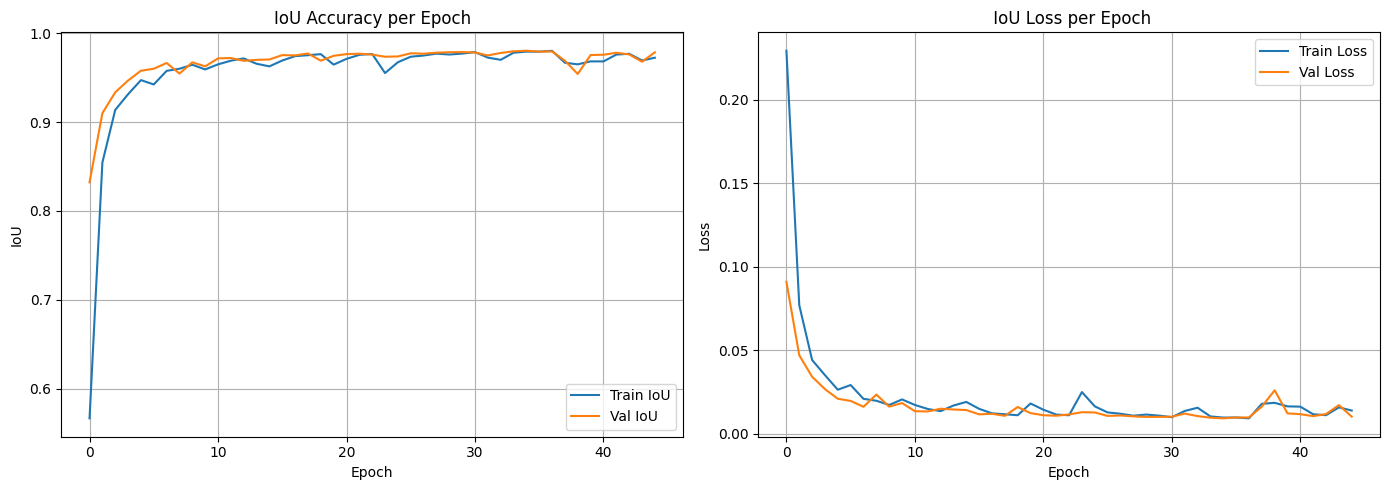

In [ ]:
# Ekstrak data dari history
history_dict = history.history

# Buat plot
plt.figure(figsize=(14, 5))

# Plot IoU (iou_metric)
plt.subplot(1, 2, 1)
plt.plot(history_dict['iou_metric'], label='Train IoU')
plt.plot(history_dict['val_iou_metric'], label='Val IoU')
plt.title('IoU Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title(' IoU Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


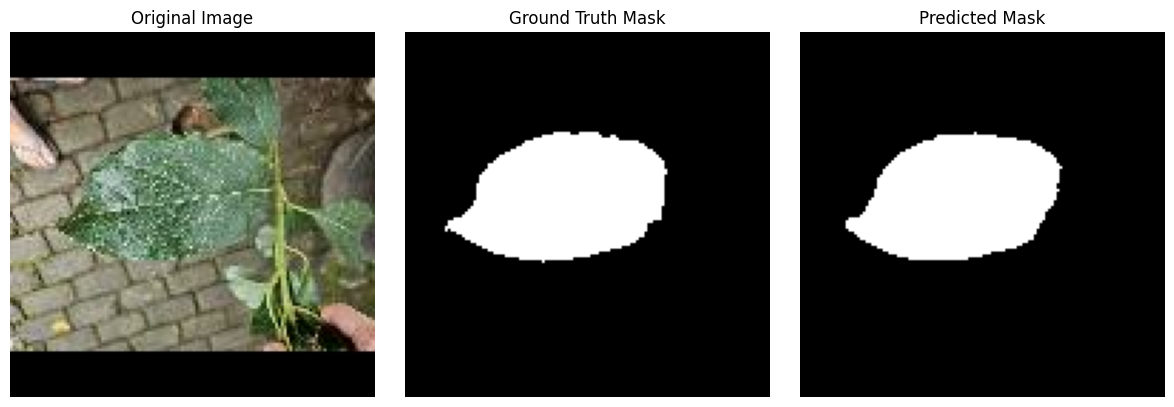

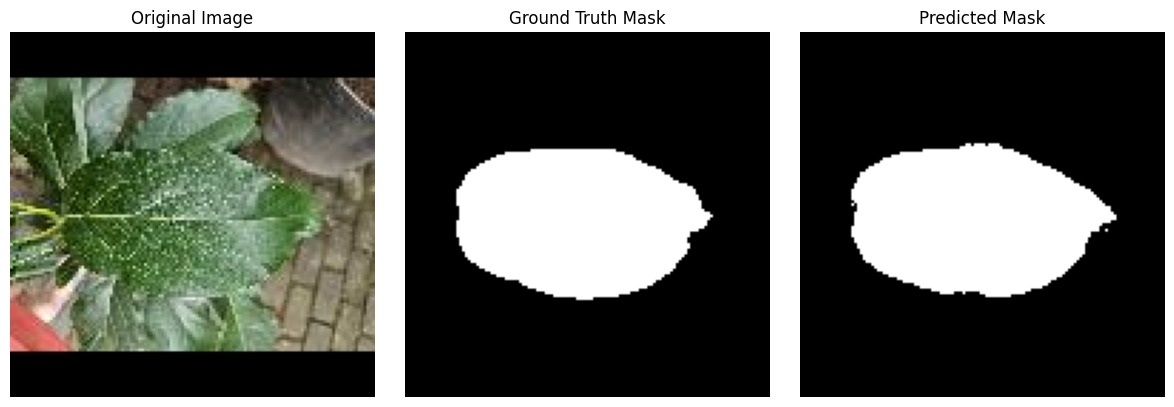

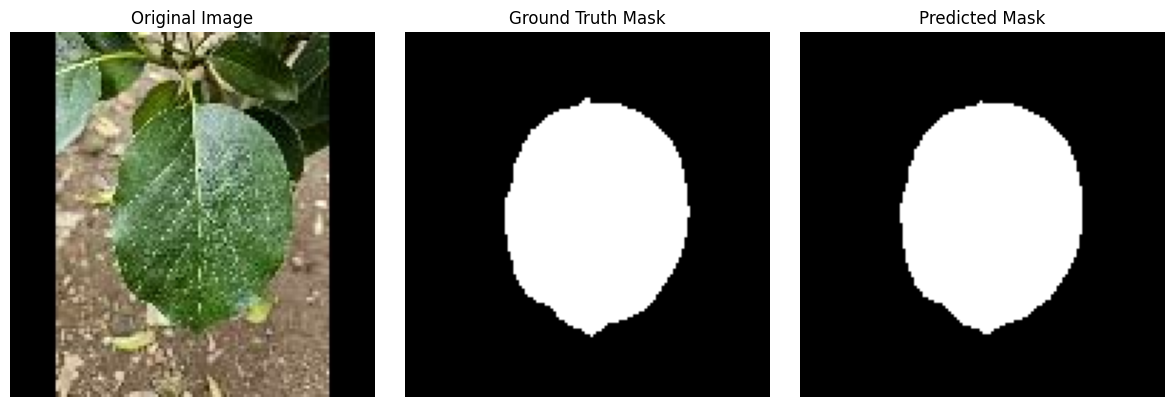

In [ ]:
def display_sample_prediction(unet_model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = unet_model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(unet_model, test_unet_ds, num_samples=3)

##**CLASSIFICATION MODEL**##

In [ ]:
from tensorflow.keras.models import load_model

# Load model U-Net dari checkpoint
unet_model = load_model('/content/drive/MyDrive/alpukat/dataset/best_unet01_model.h5')

In [ ]:
import tensorflow as tf

# Mapping string ke angka (lowercase)
reverse_label_map = {v.lower(): k for k, v in label_map.items()}

# TensorFlow lookup table
keys_tensor = tf.constant(list(reverse_label_map.keys()))
vals_tensor = tf.constant(list(reverse_label_map.values()), dtype=tf.int32)

table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
label_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

# Fungsi untuk mengambil label dari nama file
def extract_label_from_filename_tf(filename):
    filename = tf.strings.lower(filename)
    label_str = tf.strings.split(filename, '_')[0]
    return label_table.lookup(label_str)

In [ ]:
def apply_rsunet_segmentation_to_image(image, outputs, threshold=0.5):
    if isinstance(image, tf.Tensor):
        image = tf.cast(image, tf.float32)

    if image.shape[-1] != 3:
        raise ValueError(f"Image must have 3 channels. Got shape: {image.shape}")

    binary_mask = tf.cast(outputs > threshold, tf.float32)
    if len(binary_mask.shape) == 2:
        binary_mask = tf.expand_dims(binary_mask, axis=-1)
    binary_mask_rgb = tf.repeat(binary_mask, repeats=3, axis=-1)

    if binary_mask_rgb.shape != image.shape:
        binary_mask_rgb = tf.image.resize(binary_mask_rgb, image.shape[:2])

    masked_image = image * binary_mask_rgb
    return masked_image

In [ ]:
from tqdm import tqdm
import tensorflow as tf
import os

def save_masked_dataset(image_paths, model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for path in tqdm(image_paths):
        # Load image (sudah 128x128 dan normalisasi dilakukan saat load_image_and_label)
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0  # Normalisasi dilakukan sekali saja di sini jika tidak dilakukan sebelumnya

        # Predict mask
        pred = model(tf.expand_dims(image, 0), training=False)
        pred = tf.squeeze(pred, axis=0)

        # Apply mask
        masked_image = apply_rsunet_segmentation_to_image(image, pred)

        # Simpan hasil
        fname = os.path.basename(path)
        save_path = os.path.join(save_dir, fname)
        masked_uint8 = tf.image.convert_image_dtype(masked_image, tf.uint8)
        encoded = tf.image.encode_jpeg(masked_uint8)
        tf.io.write_file(save_path, encoded)

In [ ]:
save_masked_dataset(train_image_paths, unet_model, "maskedunet01_train")
save_masked_dataset(test_image_paths, unet_model, "maskedunet01_test")

100%|██████████| 1170/1170 [01:06<00:00, 17.49it/s]


In [ ]:
def load_masked_dataset(image_dir):
    image_paths = tf.io.gfile.glob(os.path.join(image_dir, '*.jpg'))
    ds = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_image_and_label(path):
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0

        filename = tf.strings.split(path, '/')[-1]
        label = extract_label_from_filename_tf(filename)
        return image, label

    return ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Batching dan prefetch
classification_train_ds_16 = load_masked_dataset("maskedunet01_train").batch(16).prefetch(tf.data.AUTOTUNE)
classification_test_ds_16 = load_masked_dataset("maskedunet01_test").batch(16).prefetch(tf.data.AUTOTUNE)

classification_train_ds_32 = load_masked_dataset("maskedunet01_train").batch(32).prefetch(tf.data.AUTOTUNE)
classification_test_ds_32 = load_masked_dataset("maskedunet01_test").batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
def classification_model(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    return tf.keras.models.Model(inputs, outputs)

In [ ]:
clf_model_class1 = classification_model()
clf_model_class2 = classification_model()

clf_model_class1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clf_model_class1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

clf_model_class2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Definisikan callbacks
callbacks_class1 = [
    ModelCheckpoint('best_class1_unet01.h5', save_best_only=True, monitor='val_loss', mode='min')
]

callbacks_class2 = [
    ModelCheckpoint('best_class2_unet01.h5', save_best_only=True, monitor='val_loss', mode='min')
]

##***TRAINING CLASS BS 16***##

In [ ]:
history_class1 = clf_model_class1.fit(
    classification_train_ds_16,   # dataset sudah dibatch dengan batch size 16
    validation_data=classification_test_ds_16,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class1
)

Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3654 - loss: 1.0873

293/293 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.3656 - loss: 1.0872 - val_accuracy: 0.4487 - val_loss: 1.0193
Epoch 2/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5261 - loss: 0.9344

293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.5263 - loss: 0.9342 - val_accuracy: 0.6427 - val_loss: 0.8324
Epoch 3/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6712 - loss: 0.7439

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.6715 - loss: 0.7434 - val_accuracy: 0.7632 - val_loss: 0.5787
Epoch 4/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7639 - loss: 0.5646

293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.7640 - loss: 0.5644 - val_accuracy: 0.7897 - val_loss: 0.5019
Epoch 5/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8088 - loss: 0.4668

293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8088 - loss: 0.4667 - val_accuracy: 0.8462 - val_loss: 0.3731
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8443 - loss: 0.4146 - val_accuracy: 0.7991 - val_loss: 0.4453
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8461 - loss: 0.3816

293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8461 - loss: 0.3816 - val_accuracy: 0.8402 - val_loss: 0.3699
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8645 - loss: 0.3432 - val_accuracy: 0.8145 - val_loss: 0.3933
Epoch 9/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.8602 - loss: 0.3321 - val_accuracy: 0.8120 - val_loss: 0.4153
Epoch 10/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8766 - loss: 0.3217

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.8766 - loss: 0.3217 - val_accuracy: 0.8957 - val_loss: 0.2678
Epoch 11/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.8901 - loss: 0.2973 - val_accuracy: 0.8863 - val_loss: 0.2808
Epoch 12/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.8949 - loss: 0.2788 - val_accuracy: 0.8761 - val_loss: 0.2817
Epoch 13/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.8979 - loss: 0.2628 - val_accuracy: 0.8803 - val_loss: 0.3017
Epoch 14/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9019 - loss: 0.2670

293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9019 - loss: 0.2670 - val_accuracy: 0.8949 - val_loss: 0.2641
Epoch 15/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9056 - loss: 0.2377 - val_accuracy: 0.8949 - val_loss: 0.2896
Epoch 16/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9114 - loss: 0.2427

293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9114 - loss: 0.2428 - val_accuracy: 0.8966 - val_loss: 0.2479
Epoch 17/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9153 - loss: 0.2288

293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9153 - loss: 0.2288 - val_accuracy: 0.9000 - val_loss: 0.2451
Epoch 18/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9232 - loss: 0.2129

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9232 - loss: 0.2131 - val_accuracy: 0.9145 - val_loss: 0.2325
Epoch 19/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9183 - loss: 0.2185

293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.9183 - loss: 0.2185 - val_accuracy: 0.9291 - val_loss: 0.1941
Epoch 20/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9285 - loss: 0.1928 - val_accuracy: 0.9094 - val_loss: 0.2252
Epoch 21/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9253 - loss: 0.1982 - val_accuracy: 0.9026 - val_loss: 0.2359
Epoch 22/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.9314 - loss: 0.1891 - val_accuracy: 0.8778 - val_loss: 0.2983
Epoch 23/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9347 - loss: 0.1815 - val_accuracy: 0.9214 - val_loss: 0.2025
Epoch 24/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.9433 - loss: 0.1560 - val_accuracy: 0.9248 - val_loss: 0.2002
Epoch 25/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9379 - loss: 0.1651 - val_accuracy: 0.9316 - val_loss: 0.1956
Epoch 26/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9418 - loss: 0.1534

293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9549 - loss: 0.1299 - val_accuracy: 0.9410 - val_loss: 0.1534
Epoch 29/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.9536 - loss: 0.1279 - val_accuracy: 0.9291 - val_loss: 0.1803
Epoch 30/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9577 - loss: 0.1219 - val_accuracy: 0.9256 - val_loss: 0.1972
Epoch 31/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9492 - loss: 0.1422

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9492 - loss: 0.1422 - val_accuracy: 0.9513 - val_loss: 0.1332
Epoch 32/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9598 - loss: 0.1104 - val_accuracy: 0.9504 - val_loss: 0.1366
Epoch 33/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9581 - loss: 0.1162 - val_accuracy: 0.9350 - val_loss: 0.1721
Epoch 34/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9583 - loss: 0.1174 - val_accuracy: 0.9419 - val_loss: 0.1791
Epoch 35/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9631 - loss: 0.1055 - val_accuracy: 0.9171 - val_loss: 0.2389
Epoch 36/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9692 - loss: 0.0986 - val_accuracy: 0.9308 - val_loss: 0.1715
Epoch 37/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9668 - loss: 0.1015

293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9667 - loss: 0.1016 - val_accuracy: 0.9607 - val_loss: 0.1115
Epoch 38/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9731 - loss: 0.0870

293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9731 - loss: 0.0871 - val_accuracy: 0.9667 - val_loss: 0.1090
Epoch 39/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9688 - loss: 0.0921 - val_accuracy: 0.9436 - val_loss: 0.1444
Epoch 40/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9734 - loss: 0.0799 - val_accuracy: 0.9479 - val_loss: 0.1791
Epoch 41/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9702 - loss: 0.0752 - val_accuracy: 0.9718 - val_loss: 0.1103
Epoch 42/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9763 - loss: 0.0770

293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9763 - loss: 0.0770 - val_accuracy: 0.9684 - val_loss: 0.1089
Epoch 43/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.9838 - loss: 0.0624 - val_accuracy: 0.9376 - val_loss: 0.1640
Epoch 44/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9758 - loss: 0.0711 - val_accuracy: 0.9632 - val_loss: 0.1100
Epoch 45/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9761 - loss: 0.0776

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9761 - loss: 0.0776 - val_accuracy: 0.9803 - val_loss: 0.0994
Epoch 46/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9808 - loss: 0.0633

293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9807 - loss: 0.0634 - val_accuracy: 0.9795 - val_loss: 0.0955
Epoch 47/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9843 - loss: 0.0550

293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9842 - loss: 0.0551 - val_accuracy: 0.9692 - val_loss: 0.0896
Epoch 48/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.9820 - loss: 0.0536 - val_accuracy: 0.9615 - val_loss: 0.1211
Epoch 49/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9868 - loss: 0.0401 - val_accuracy: 0.9615 - val_loss: 0.1004
Epoch 50/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9808 - loss: 0.0565 - val_accuracy: 0.9641 - val_loss: 0.1041
Epoch 51/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9878 - loss: 0.0458

293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9878 - loss: 0.0458 - val_accuracy: 0.9829 - val_loss: 0.0749
Epoch 52/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9869 - loss: 0.0344 - val_accuracy: 0.9513 - val_loss: 0.1564
Epoch 53/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9899 - loss: 0.0312 - val_accuracy: 0.9128 - val_loss: 0.2381
Epoch 54/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9837 - loss: 0.0531 - val_accuracy: 0.9615 - val_loss: 0.1004
Epoch 55/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9740 - loss: 0.0774 - val_accuracy: 0.9786 - val_loss: 0.0801
Epoch 56/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9867 - loss: 0.0502

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9868 - loss: 0.0502 - val_accuracy: 0.9846 - val_loss: 0.0696
Epoch 57/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9869 - loss: 0.0408 - val_accuracy: 0.9803 - val_loss: 0.0877
Epoch 58/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9850 - loss: 0.0439 - val_accuracy: 0.9564 - val_loss: 0.1242
Epoch 59/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9818 - loss: 0.0734 - val_accuracy: 0.9726 - val_loss: 0.1288
Epoch 60/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9908 - loss: 0.0306 - val_accuracy: 0.9701 - val_loss: 0.0872
Epoch 61/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9854 - loss: 0.0475 - val_accuracy: 0.9838 - val_loss: 0.0709
Epoch 62/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9925 - loss: 0.0231

293/293 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9925 - loss: 0.0231 - val_accuracy: 0.9889 - val_loss: 0.0575
Epoch 63/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.9902 - loss: 0.0297 - val_accuracy: 0.9778 - val_loss: 0.0870
Epoch 64/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9955 - loss: 0.0214 - val_accuracy: 0.9786 - val_loss: 0.0603
Epoch 65/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.9841 - loss: 0.0507 - val_accuracy: 0.9684 - val_loss: 0.1240
Epoch 66/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9921 - loss: 0.0296 - val_accuracy: 0.8829 - val_loss: 0.3870
Epoch 67/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9827 - loss: 0.0569 - val_accuracy: 0.9872 - val_loss: 0.0852
Epoch 68/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9958 - loss: 0.0148 - val_accuracy: 0.9846 - val_loss: 0.0703
Epoch 69/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9849 - loss: 0.0544

293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9967 - loss: 0.0138 - val_accuracy: 0.9880 - val_loss: 0.0480
Epoch 81/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9962 - loss: 0.0206 - val_accuracy: 0.9821 - val_loss: 0.0860
Epoch 82/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9866 - loss: 0.0459 - val_accuracy: 0.9752 - val_loss: 0.0925
Epoch 83/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9926 - loss: 0.0252 - val_accuracy: 0.9795 - val_loss: 0.0686
Epoch 84/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.9931 - loss: 0.0222 - val_accuracy: 0.9838 - val_loss: 0.0594
Epoch 85/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9977 - loss: 0.0116 - val_accuracy: 0.9786 - val_loss: 0.1020
Epoch 86/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9772 - loss: 0.0700 - val_accuracy: 0.9718 - val_loss: 0.0961
Epoch 87/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9906 - loss: 0.0254

293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.9876 - loss: 0.0382 - val_accuracy: 0.9880 - val_loss: 0.0468
Epoch 93/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9954 - loss: 0.0142 - val_accuracy: 0.9889 - val_loss: 0.0638
Epoch 94/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9979 - loss: 0.0091 - val_accuracy: 0.9829 - val_loss: 0.0920
Epoch 95/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9771 - loss: 0.0656 - val_accuracy: 0.9752 - val_loss: 0.0864
Epoch 96/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9993 - loss: 0.0075 - val_accuracy: 0.9897 - val_loss: 0.0725
Epoch 97/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 0.9889 - val_loss: 0.0837
Epoch 98/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.9837 - loss: 0.0464 - val_accuracy: 0.9915 - val_loss: 0.0600
Epoch 99/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9977 - loss: 0.0084

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

<Figure size 800x600 with 0 Axes>

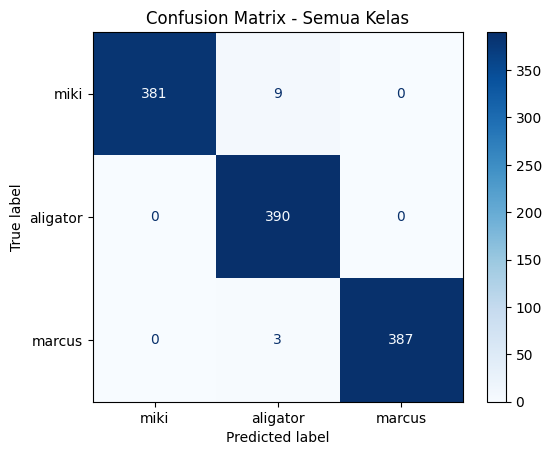

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       1.00      0.98      0.99       390
    aligator       0.97      1.00      0.98       390
      marcus       1.00      0.99      1.00       390

    accuracy                           0.99      1170
   macro avg       0.99      0.99      0.99      1170
weighted avg       0.99      0.99      0.99      1170

              precision    recall  f1-score      support
miki           1.000000  0.976923  0.988327   390.000000
aligator       0.970149  1.000000  0.984848   390.000000
marcus         1.000000  0.992308  0.996139   390.000000
accuracy       0.989744  0.989744  0.989744     0.989744
macro avg      0.990050  0.989744  0.989771  1170.000000
weighted avg   0.990050  0.989744  0.989771  1170.000000


In [ ]:
# Inisialisasi
y_true_all = []
y_pred_all = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_16:
    predictions = clf_model_class1.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all.extend(label_batch.numpy())
    y_pred_all.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
display_labels = [label_map[i] for i in sorted(set(y_true_all + y_pred_all))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all, y_pred_all, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df = pd.DataFrame(
    classification_report(
        y_true_all,
        y_pred_all,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df)

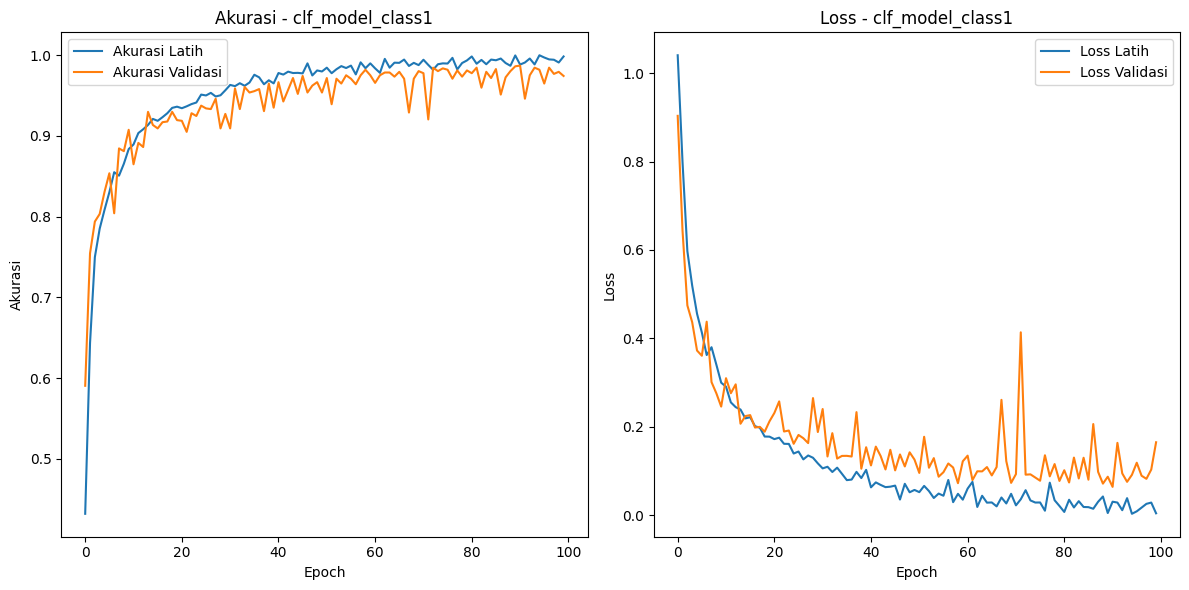

In [ ]:
import matplotlib.pyplot as plt

# Plot History untuk clf_model_class1
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class1
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class1.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class1.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class1.history['loss'], label='Loss Latih')
plt.plot(history_class1.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

##***TRAINING CLASS BS 32***##

In [ ]:
history_class2 = clf_model_class2.fit(
    classification_train_ds_32,   # dataset sudah dibatch dengan batch size 32
    validation_data=classification_test_ds_32,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class2
)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3640 - loss: 1.0912

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.3642 - loss: 1.0912 - val_accuracy: 0.5188 - val_loss: 1.0140
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.5119 - loss: 0.9697 - val_accuracy: 0.5316 - val_loss: 1.0296
Epoch 3/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6630 - loss: 0.7462

147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.6634 - loss: 0.7457 - val_accuracy: 0.7701 - val_loss: 0.5984
Epoch 4/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7409 - loss: 0.6122

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.7410 - loss: 0.6119 - val_accuracy: 0.7761 - val_loss: 0.5318
Epoch 5/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7717 - loss: 0.5543

147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7719 - loss: 0.5539 - val_accuracy: 0.7718 - val_loss: 0.4978
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.8082 - loss: 0.4765 - val_accuracy: 0.7846 - val_loss: 0.4985
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.8194 - loss: 0.4497 - val_accuracy: 0.7547 - val_loss: 0.5439
Epoch 8/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8080 - loss: 0.4796

147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.8083 - loss: 0.4790 - val_accuracy: 0.8171 - val_loss: 0.4131
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.8390 - loss: 0.4020 - val_accuracy: 0.8171 - val_loss: 0.4153
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8426 - loss: 0.3857 - val_accuracy: 0.8034 - val_loss: 0.4546
Epoch 11/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.8562 - loss: 0.3639 - val_accuracy: 0.8009 - val_loss: 0.4536
Epoch 12/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.8609 - loss: 0.3539 - val_accuracy: 0.7821 - val_loss: 0.4882
Epoch 13/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.8655 - loss: 0.3544 - val_accuracy: 0.7863 - val_loss: 0.4920
Epoch 14/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.8716 - loss: 0.3290 - val_accuracy: 0.7709 - val_loss: 0.5261
Epoch 15/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.8613 - loss: 0.3

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.8776 - loss: 0.3255 - val_accuracy: 0.8444 - val_loss: 0.3343
Epoch 17/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.8810 - loss: 0.3005 - val_accuracy: 0.7949 - val_loss: 0.4494
Epoch 18/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.8805 - loss: 0.3136 - val_accuracy: 0.8419 - val_loss: 0.3391
Epoch 19/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.8885 - loss: 0.2756 - val_accuracy: 0.7889 - val_loss: 0.4721
Epoch 20/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.8878 - loss: 0.2800 - val_accuracy: 0.8179 - val_loss: 0.3788
Epoch 21/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8977 - loss: 0.2665

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.8977 - loss: 0.2664 - val_accuracy: 0.8701 - val_loss: 0.2938
Epoch 22/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9074 - loss: 0.2350 - val_accuracy: 0.8735 - val_loss: 0.3034
Epoch 23/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.9041 - loss: 0.2413 - val_accuracy: 0.8564 - val_loss: 0.3588
Epoch 24/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.9119 - loss: 0.2287 - val_accuracy: 0.8581 - val_loss: 0.3390
Epoch 25/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.9080 - loss: 0.2477 - val_accuracy: 0.8718 - val_loss: 0.3038
Epoch 26/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9164 - loss: 0.2237

147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.9164 - loss: 0.2236 - val_accuracy: 0.8846 - val_loss: 0.2625
Epoch 27/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9230 - loss: 0.2151 - val_accuracy: 0.8915 - val_loss: 0.2803
Epoch 28/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9175 - loss: 0.2099 - val_accuracy: 0.8479 - val_loss: 0.3780
Epoch 29/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9151 - loss: 0.2295

147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.9151 - loss: 0.2295 - val_accuracy: 0.9111 - val_loss: 0.2228
Epoch 30/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9316 - loss: 0.1901

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.9317 - loss: 0.1900 - val_accuracy: 0.9205 - val_loss: 0.1883
Epoch 31/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.9351 - loss: 0.1828 - val_accuracy: 0.9060 - val_loss: 0.2128
Epoch 32/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.9314 - loss: 0.1887 - val_accuracy: 0.9137 - val_loss: 0.1935
Epoch 33/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.9409 - loss: 0.1699 - val_accuracy: 0.8991 - val_loss: 0.2189
Epoch 34/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9317 - loss: 0.1732 - val_accuracy: 0.8453 - val_loss: 0.3653
Epoch 35/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9379 - loss: 0.1770 - val_accuracy: 0.8658 - val_loss: 0.3032
Epoch 36/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9345 - loss: 0.1701

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9345 - loss: 0.1700 - val_accuracy: 0.9291 - val_loss: 0.1883
Epoch 37/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.9405 - loss: 0.1585 - val_accuracy: 0.8983 - val_loss: 0.2164
Epoch 38/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9314 - loss: 0.1801 - val_accuracy: 0.9120 - val_loss: 0.1991
Epoch 39/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9382 - loss: 0.1637

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9382 - loss: 0.1639 - val_accuracy: 0.9436 - val_loss: 0.1564
Epoch 40/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9523 - loss: 0.1403

147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9523 - loss: 0.1403 - val_accuracy: 0.9453 - val_loss: 0.1466
Epoch 41/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9386 - loss: 0.1536 - val_accuracy: 0.9470 - val_loss: 0.1504
Epoch 42/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.9432 - loss: 0.1367 - val_accuracy: 0.9419 - val_loss: 0.1580
Epoch 43/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9590 - loss: 0.1161 - val_accuracy: 0.9333 - val_loss: 0.1543
Epoch 44/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9606 - loss: 0.1151

147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9606 - loss: 0.1152 - val_accuracy: 0.9368 - val_loss: 0.1456
Epoch 45/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9500 - loss: 0.1314 - val_accuracy: 0.9154 - val_loss: 0.1724
Epoch 46/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9561 - loss: 0.1253 - val_accuracy: 0.9479 - val_loss: 0.1456
Epoch 47/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9628 - loss: 0.1092 - val_accuracy: 0.9444 - val_loss: 0.1654
Epoch 48/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9621 - loss: 0.1078 - val_accuracy: 0.9316 - val_loss: 0.1644
Epoch 49/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9603 - loss: 0.1079 - val_accuracy: 0.9325 - val_loss: 0.2017
Epoch 50/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.9557 - loss: 0.1243 - val_accuracy: 0.9436 - val_loss: 0.1540
Epoch 51/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.9533 - loss: 0.12

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9562 - loss: 0.1111 - val_accuracy: 0.9530 - val_loss: 0.1280
Epoch 53/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9538 - loss: 0.1186

147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9539 - loss: 0.1184 - val_accuracy: 0.9641 - val_loss: 0.1140
Epoch 54/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.9689 - loss: 0.0822 - val_accuracy: 0.9496 - val_loss: 0.1251
Epoch 55/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.9688 - loss: 0.0922 - val_accuracy: 0.9385 - val_loss: 0.1835
Epoch 56/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.9665 - loss: 0.1013 - val_accuracy: 0.9333 - val_loss: 0.1779
Epoch 57/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9627 - loss: 0.1112 - val_accuracy: 0.9521 - val_loss: 0.1534
Epoch 58/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.9694 - loss: 0.0905 - val_accuracy: 0.9624 - val_loss: 0.1189
Epoch 59/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.9715 - loss: 0.0806 - val_accuracy: 0.9530 - val_loss: 0.1473
Epoch 60/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9696 - loss: 0.0

147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.9696 - loss: 0.0812 - val_accuracy: 0.9658 - val_loss: 0.0988
Epoch 61/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.9723 - loss: 0.0776 - val_accuracy: 0.9359 - val_loss: 0.1495
Epoch 62/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.9708 - loss: 0.0793 - val_accuracy: 0.9462 - val_loss: 0.1377
Epoch 63/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9771 - loss: 0.0741 - val_accuracy: 0.9547 - val_loss: 0.1355
Epoch 64/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9762 - loss: 0.0741

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9762 - loss: 0.0741 - val_accuracy: 0.9761 - val_loss: 0.0961
Epoch 65/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9775 - loss: 0.0690 - val_accuracy: 0.9470 - val_loss: 0.1319
Epoch 66/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9711 - loss: 0.0784

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9711 - loss: 0.0783 - val_accuracy: 0.9744 - val_loss: 0.0881
Epoch 67/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9802 - loss: 0.0560 - val_accuracy: 0.9692 - val_loss: 0.1035
Epoch 68/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9658 - loss: 0.0912 - val_accuracy: 0.9667 - val_loss: 0.1294
Epoch 69/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9812 - loss: 0.0498 - val_accuracy: 0.9709 - val_loss: 0.1063
Epoch 70/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9820 - loss: 0.0520

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.9819 - loss: 0.0522 - val_accuracy: 0.9786 - val_loss: 0.0739
Epoch 71/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.9845 - loss: 0.0465 - val_accuracy: 0.9607 - val_loss: 0.1296
Epoch 72/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.9872 - loss: 0.0420 - val_accuracy: 0.9359 - val_loss: 0.1573
Epoch 73/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.9724 - loss: 0.0637 - val_accuracy: 0.9692 - val_loss: 0.1114
Epoch 74/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9840 - loss: 0.0527 - val_accuracy: 0.9444 - val_loss: 0.1720
Epoch 75/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9801 - loss: 0.0574 - val_accuracy: 0.9564 - val_loss: 0.1371
Epoch 76/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.9852 - loss: 0.0432 - val_accuracy: 0.9556 - val_loss: 0.1528
Epoch 77/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9835 - loss: 0

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.9778 - loss: 0.0549 - val_accuracy: 0.9838 - val_loss: 0.0698
Epoch 81/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9831 - loss: 0.0471 - val_accuracy: 0.9385 - val_loss: 0.2497
Epoch 82/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9774 - loss: 0.0599

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9775 - loss: 0.0597 - val_accuracy: 0.9838 - val_loss: 0.0673
Epoch 83/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.9887 - loss: 0.0354 - val_accuracy: 0.9709 - val_loss: 0.0888
Epoch 84/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.9917 - loss: 0.0312 - val_accuracy: 0.9667 - val_loss: 0.1366
Epoch 85/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9825 - loss: 0.0520 - val_accuracy: 0.9855 - val_loss: 0.0693
Epoch 86/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.9817 - loss: 0.0608 - val_accuracy: 0.9761 - val_loss: 0.1033
Epoch 87/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.9877 - loss: 0.0361 - val_accuracy: 0.9838 - val_loss: 0.0851
Epoch 88/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9944 - loss: 0.0179 - val_accuracy: 0.9385 - val_loss: 0.2235
Epoch 89/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.9854 - loss: 0.03

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

<Figure size 800x600 with 0 Axes>

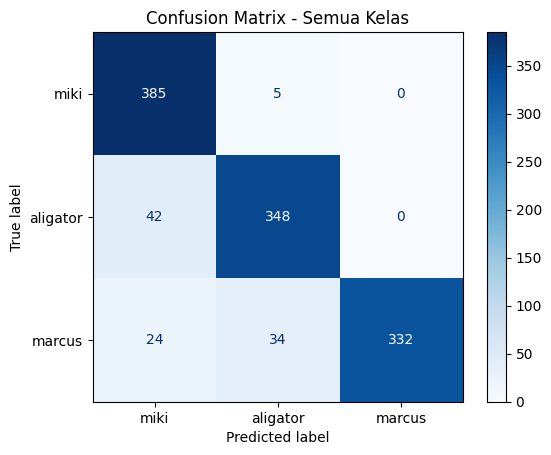

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       0.85      0.99      0.92       390
    aligator       0.90      0.89      0.90       390
      marcus       1.00      0.85      0.92       390

    accuracy                           0.91      1170
   macro avg       0.92      0.91      0.91      1170
weighted avg       0.92      0.91      0.91      1170

              precision    recall  f1-score      support
miki           0.853659  0.987179  0.915577   390.000000
aligator       0.899225  0.892308  0.895753   390.000000
marcus         1.000000  0.851282  0.919668   390.000000
accuracy       0.910256  0.910256  0.910256     0.910256
macro avg      0.917628  0.910256  0.910332  1170.000000
weighted avg   0.917628  0.910256  0.910332  1170.000000


In [ ]:
# Inisialisasi
y_true_all2 = []
y_pred_all2 = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_32:
    predictions = clf_model_class2.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all2.extend(label_batch.numpy())
    y_pred_all2.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all2, y_pred_all2)
display_labels = [label_map[i] for i in sorted(set(y_true_all2 + y_pred_all2))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all2, y_pred_all2, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df2 = pd.DataFrame(
    classification_report(
        y_true_all2,
        y_pred_all2,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df2)

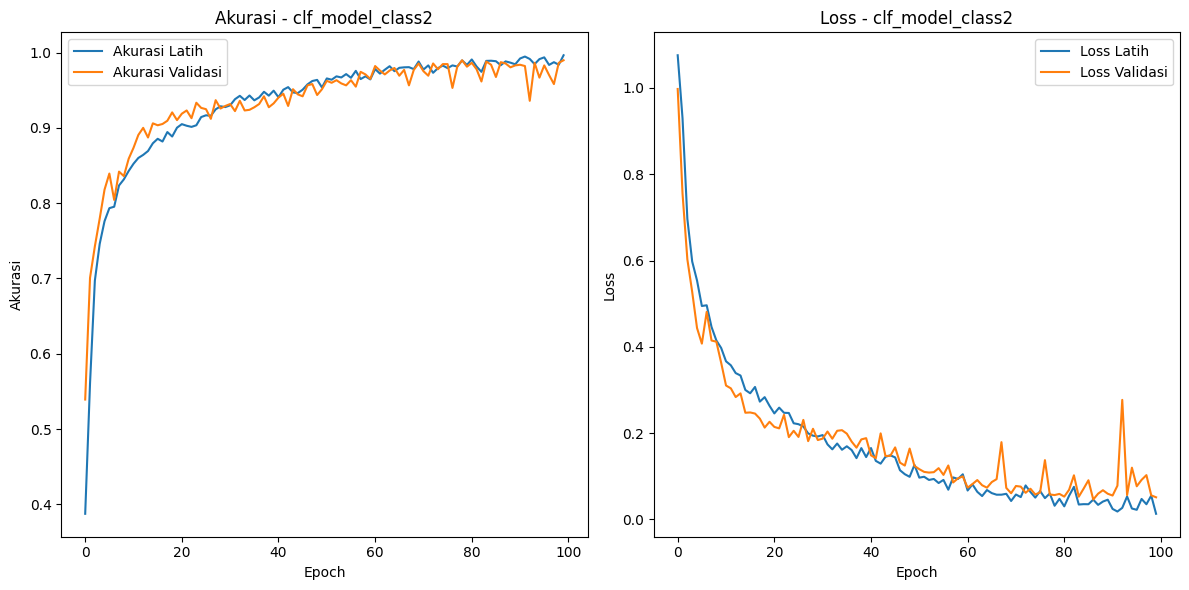

In [ ]:
# Plot History untuk clf_model_class2
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class2
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class2.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class2.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class2.history['loss'], label='Loss Latih')
plt.plot(history_class2.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


##**VISUALISASI AKHIR**##

In [ ]:
def visualize_all_test_images(image_paths, mask_paths, labels, masked_image_paths, clf_model_class2, label_map, max_visualize=None):
    label_names = label_map
    num_samples = len(image_paths)

    if max_visualize is not None:
        num_samples = min(num_samples, max_visualize)

    for i in range(num_samples):
        image_path = image_paths[i]
        mask_path = mask_paths[i]
        masked_image_path = masked_image_paths[i]
        true_label_idx = labels[i]

        # Load original image
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0

        # Load ground truth mask (if available)
        try:
            mask_raw = tf.io.read_file(mask_path)
            gt_mask = tf.image.decode_jpeg(mask_raw, channels=1)
            gt_mask = tf.image.resize(gt_mask, [128, 128])
            gt_mask = tf.cast(gt_mask, tf.float32)
        except:
            gt_mask = tf.zeros((128, 128, 1), dtype=tf.float32)

        # Load masked image (hasil segmentasi offline)
        masked_image_raw = tf.io.read_file(masked_image_path)
        masked_image = tf.image.decode_jpeg(masked_image_raw, channels=3)
        masked_image = tf.image.resize(masked_image, [128, 128])
        masked_image = tf.cast(masked_image, tf.float32) / 255.0

        # Predict label with classifier
        pred_probs = clf_model_class2(tf.expand_dims(masked_image, 0), training=False)
        pred_label_idx = int(tf.argmax(pred_probs, axis=-1).numpy()[0])

        # Convert label index to string
        true_label_str = label_names.get(true_label_idx, f"Unknown ({true_label_idx})")
        pred_label_str = label_names.get(pred_label_idx, f"Unknown ({pred_label_idx})")

        # Visualisasi
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(image.numpy())
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(gt_mask, cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(masked_image.numpy())
        axes[2].set_title("Masked Image (Hasil Segmentasi)")
        axes[2].axis('off')

        axes[3].imshow(masked_image.numpy())
        axes[3].set_title(f"Label Asli: {true_label_str}\nPrediksi: {pred_label_str}")
        axes[3].axis('off')

        filename = os.path.basename(image_path)
        plt.suptitle(f"Visualisasi: {filename}", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()


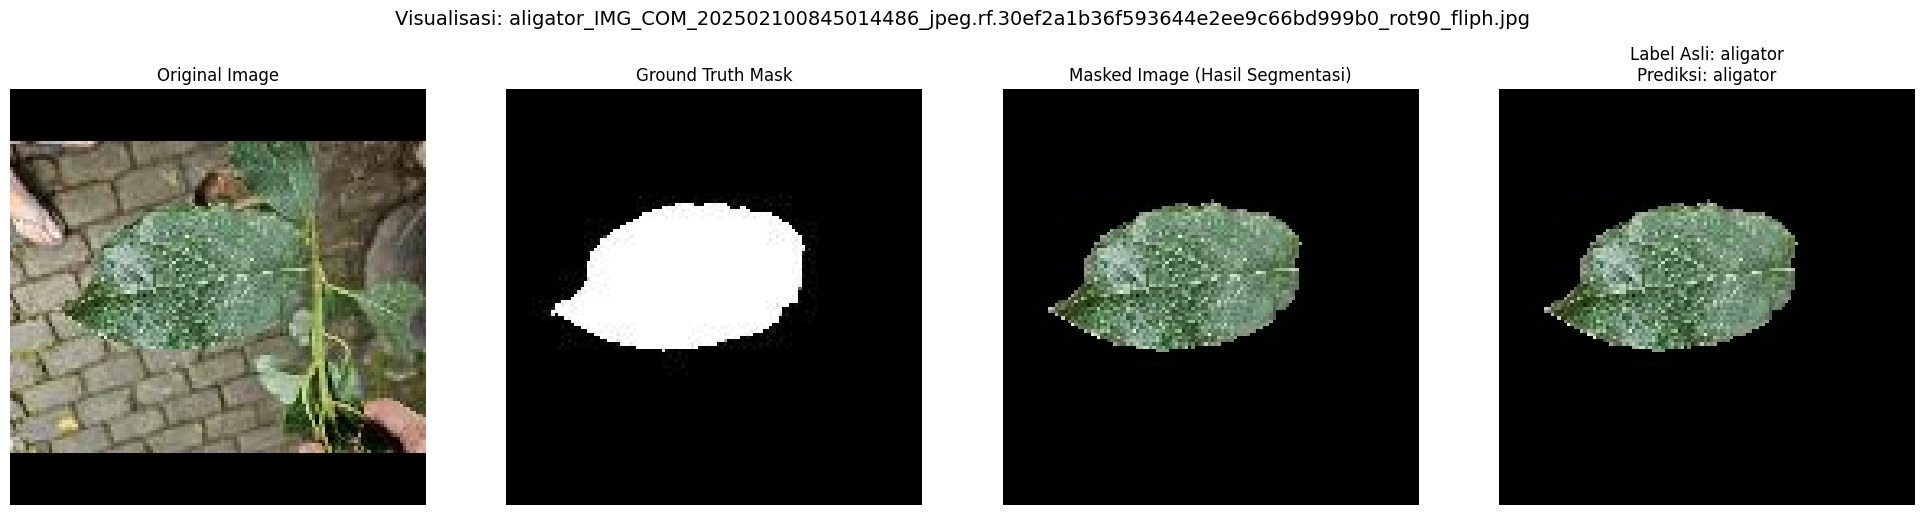

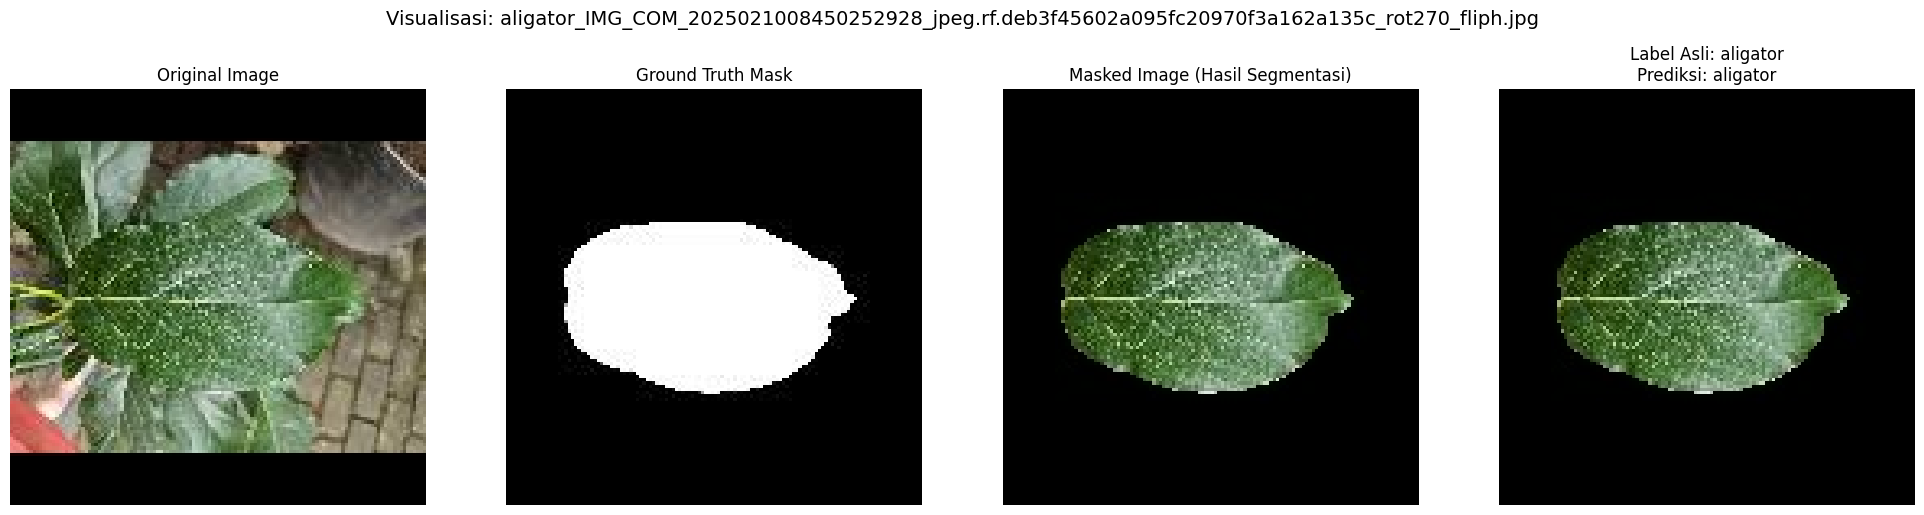

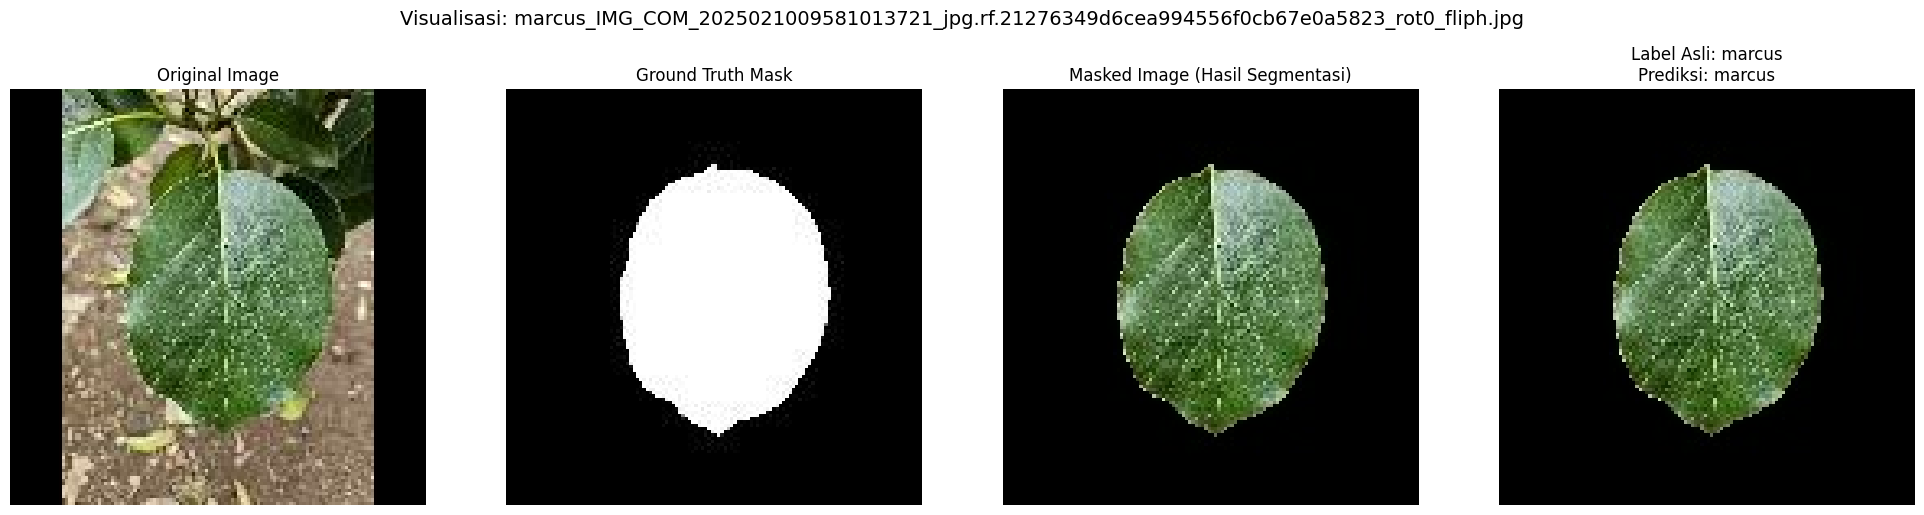

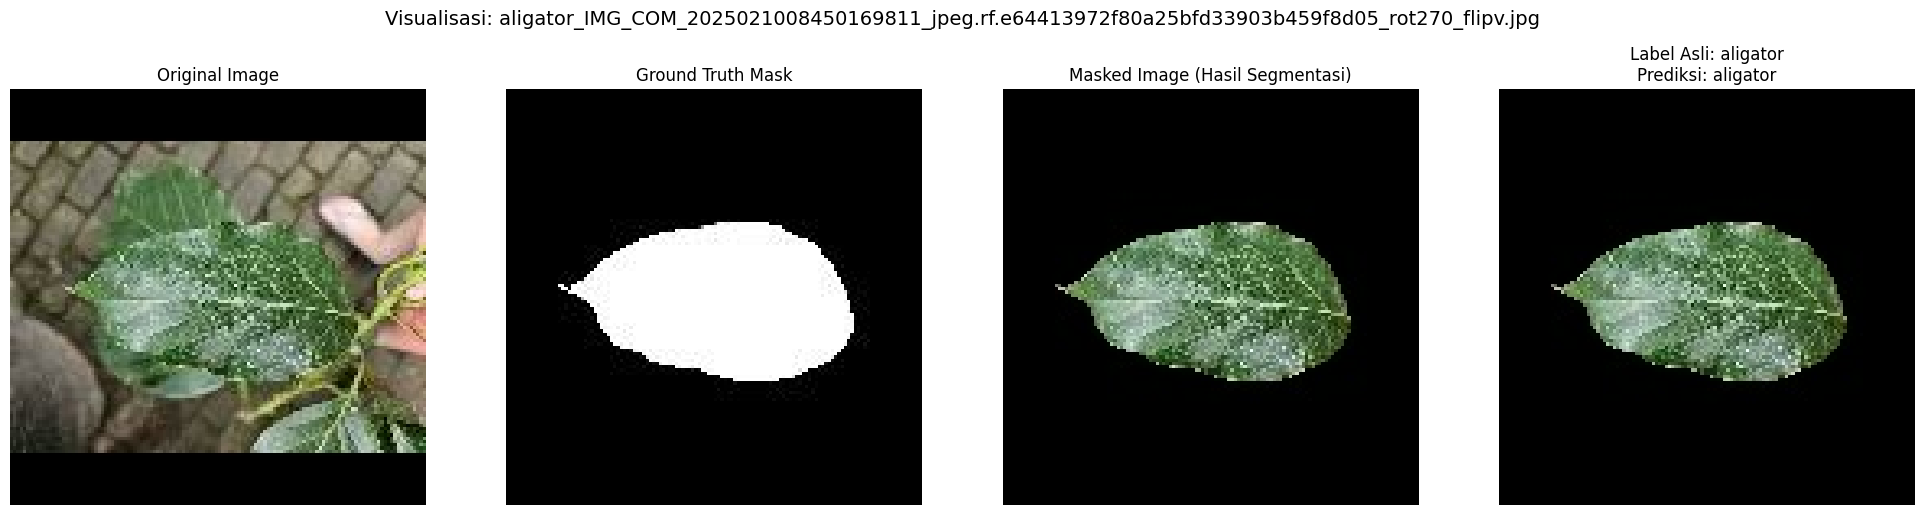

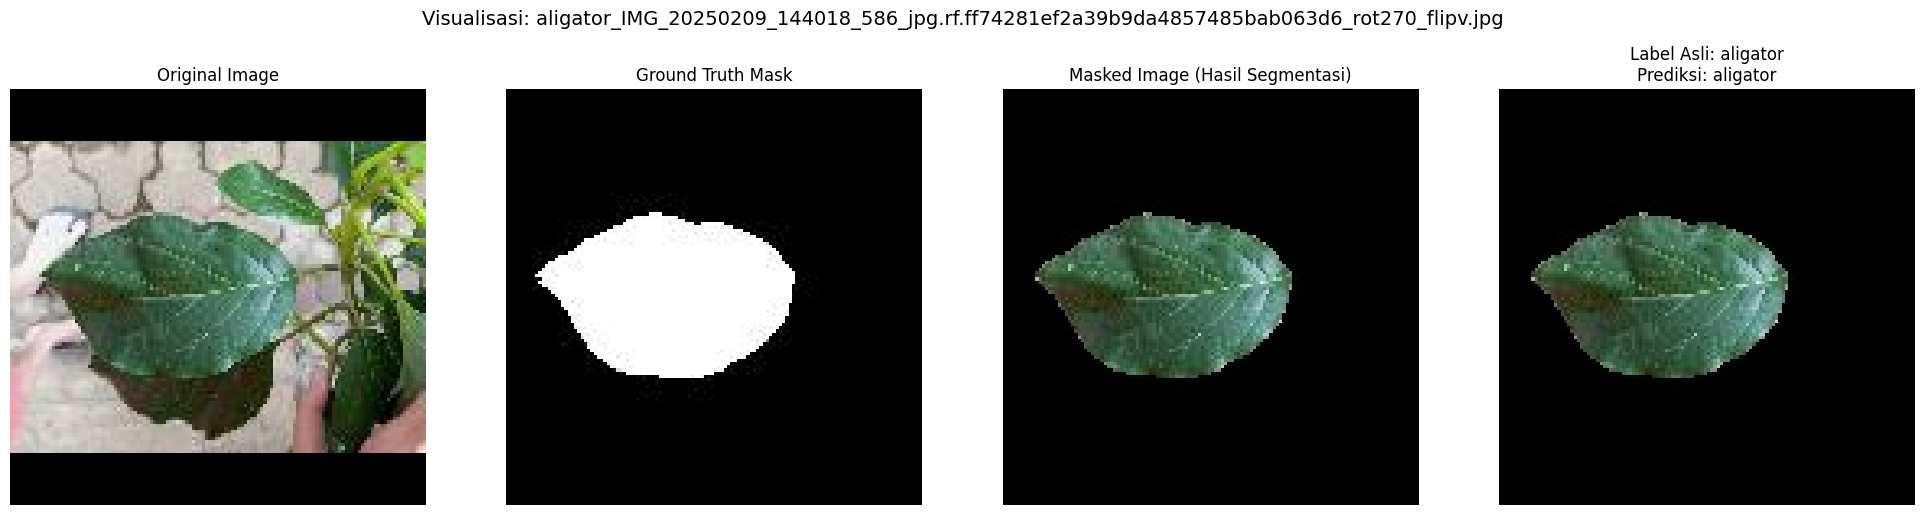

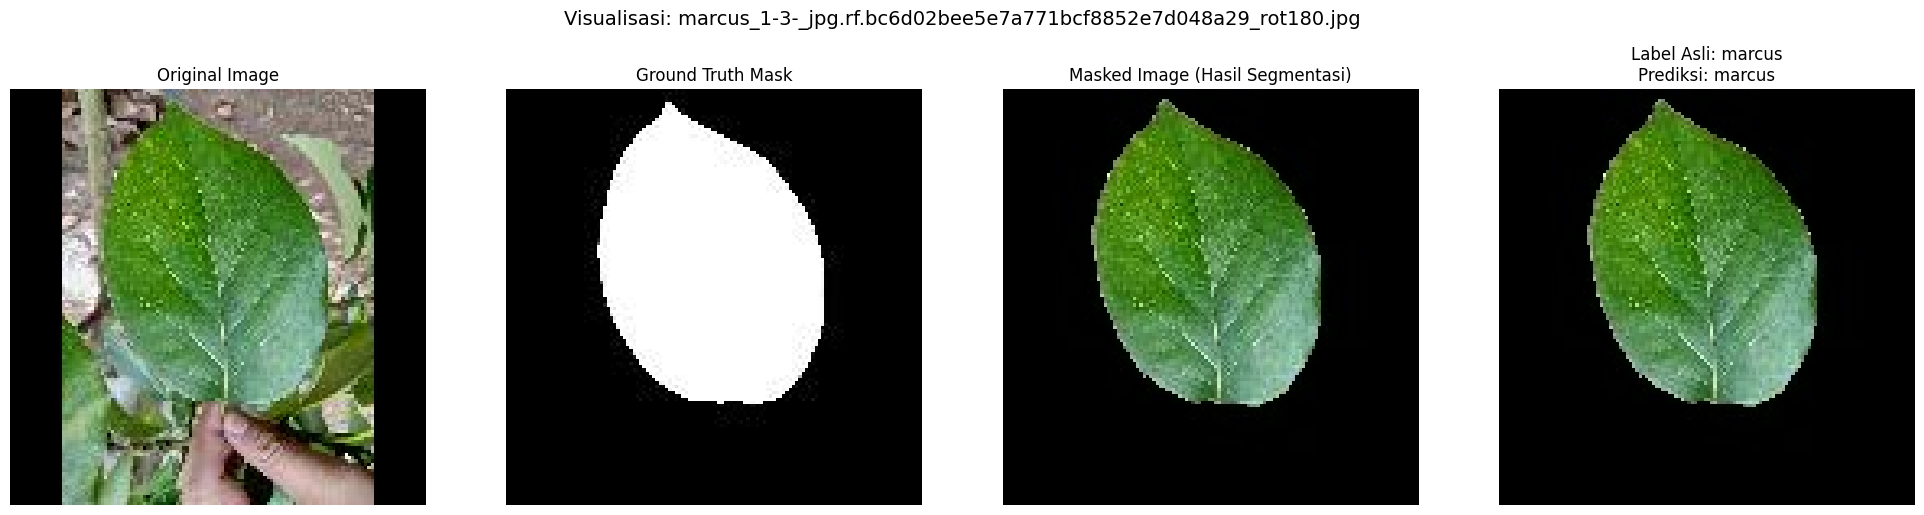

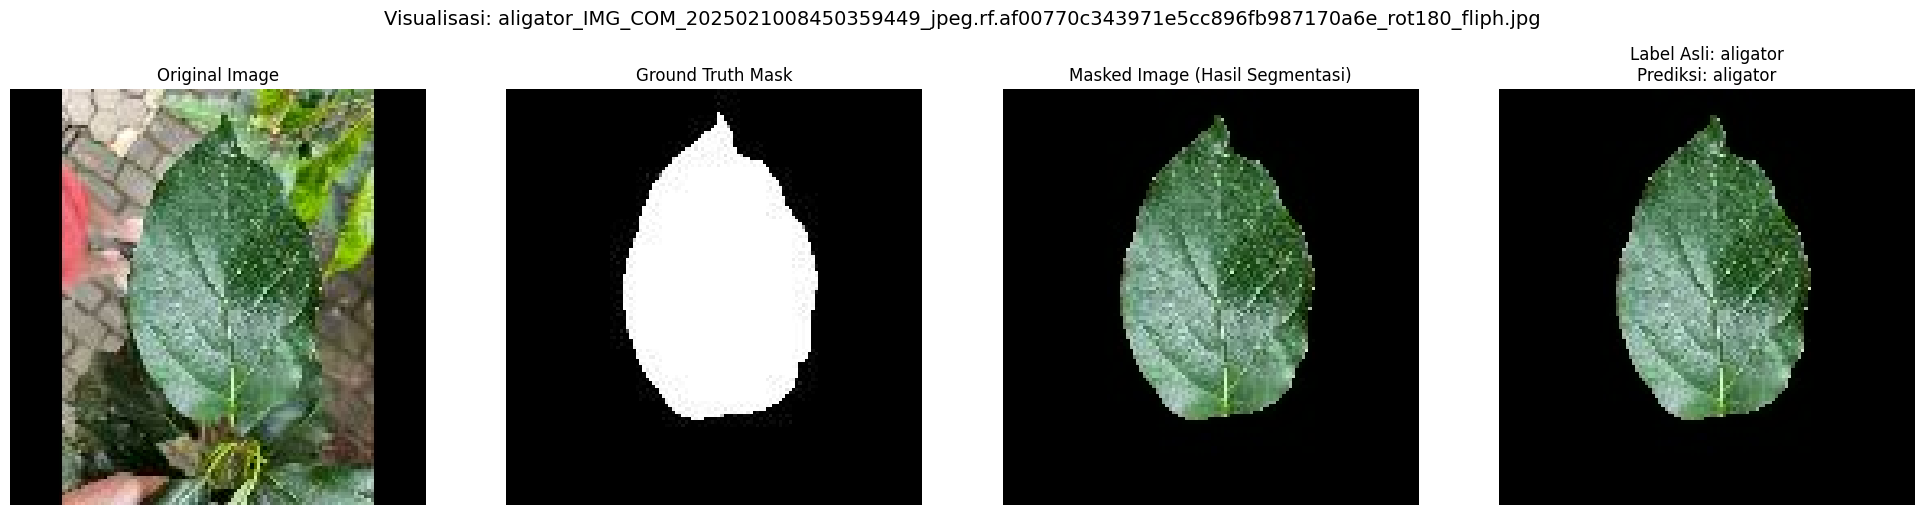

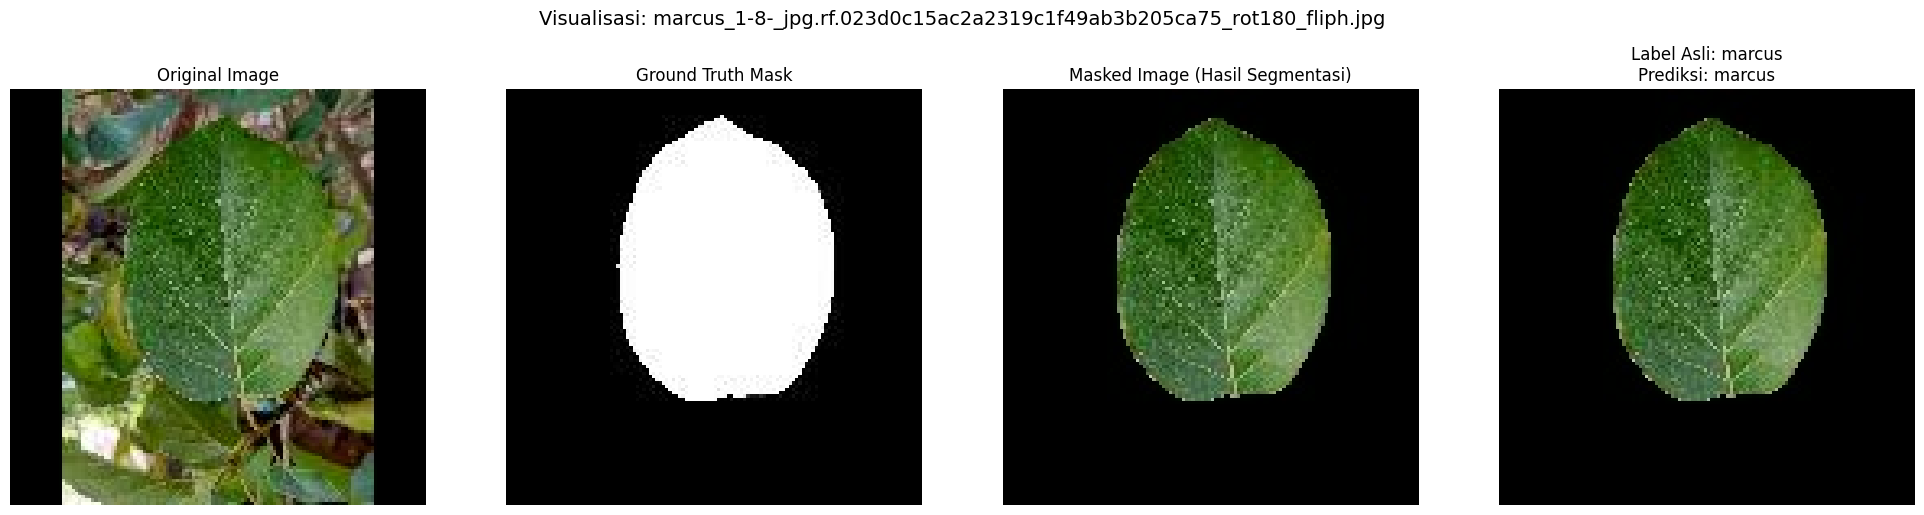

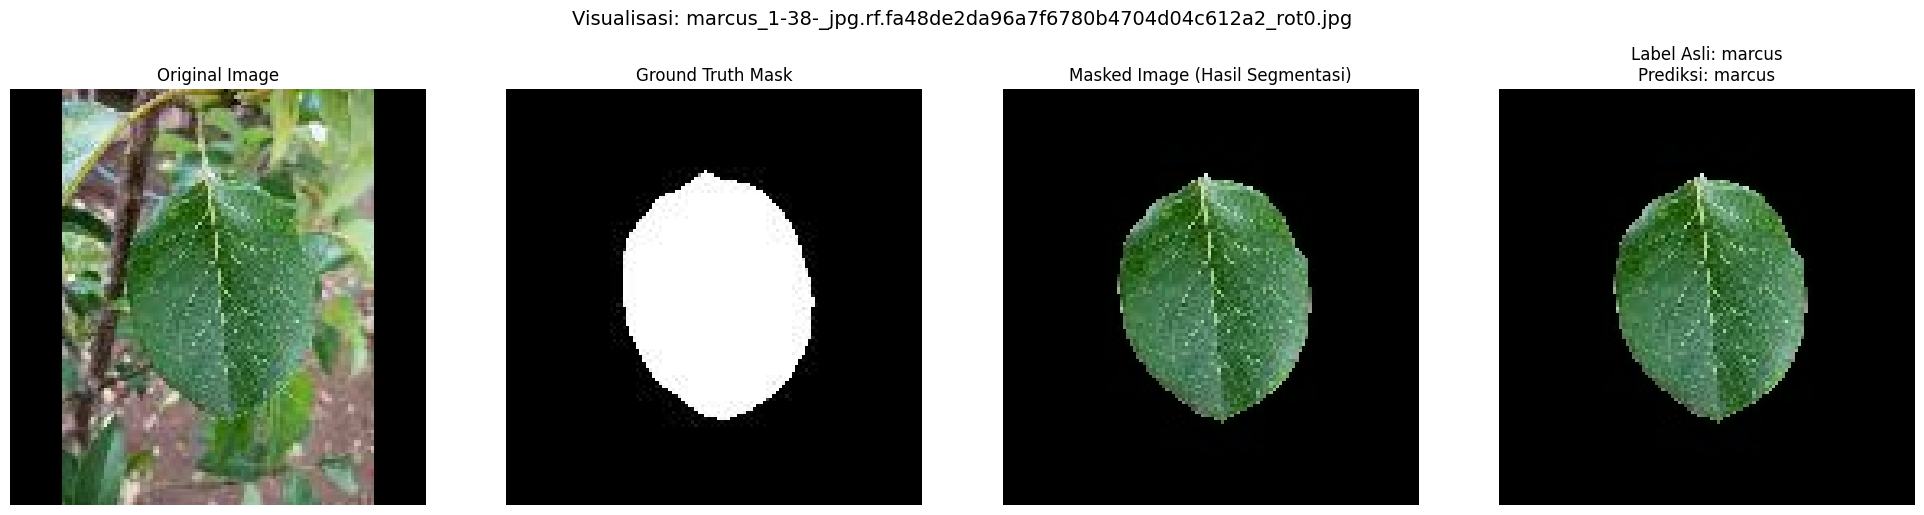

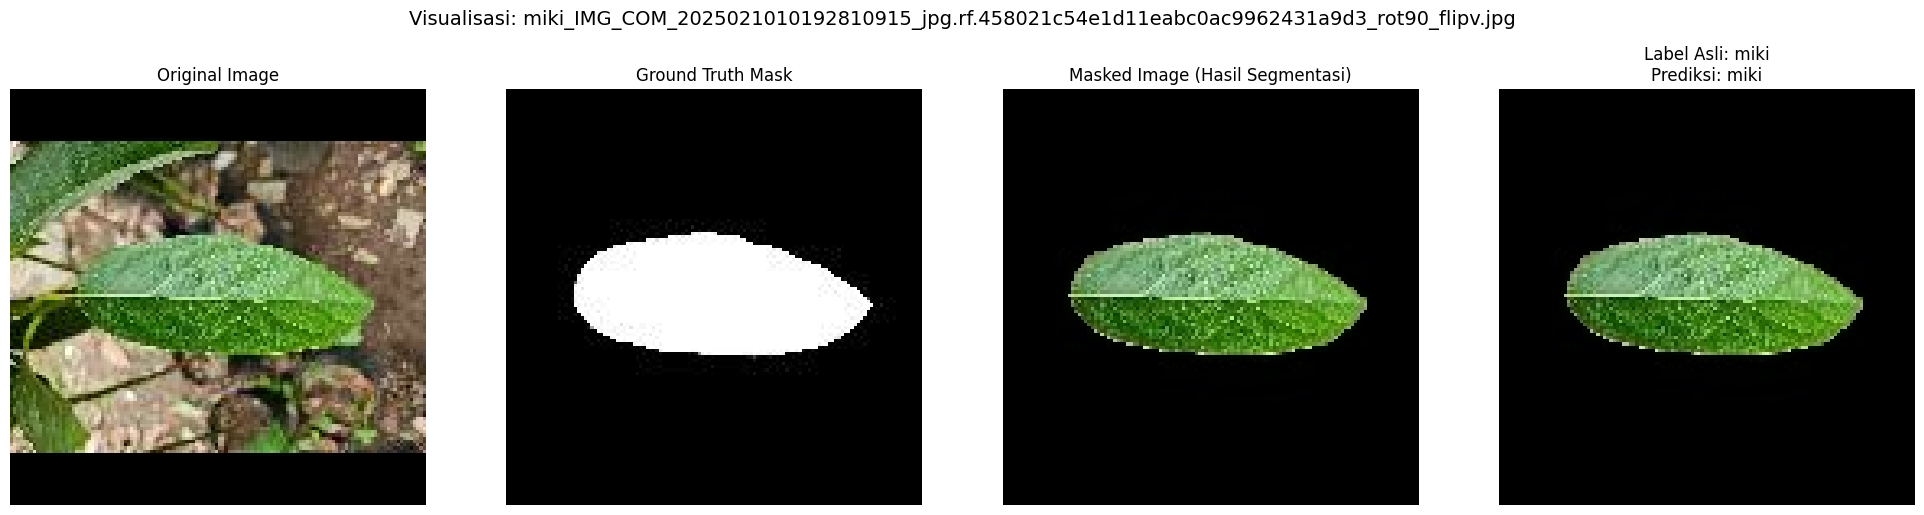

In [ ]:
visualize_all_test_images(
    image_paths=test_image_paths,
    mask_paths=test_mask_paths,
    labels=test_labels,
    masked_image_paths=[os.path.join("maskedrsunet01_test", os.path.basename(p)) for p in test_image_paths],  # list of saved masked image filepaths
    clf_model_class2=clf_model_class2,
    label_map=label_map,
    max_visualize=10
)